# GO/STOP! object detection 시스템 만들기
## 자율주행 보조장치 (1) KITTI Dataset
* 1) 사람이 카메라에 감지되면 정지
* 2) 차량이 일정 크기 이상으로 감지되면 정지

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), 'aiffel/object_detection/data')

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling kitti-train.tfrecord...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling kitti-validation.tfrecord...:   0%|          | 0/423 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling kitti-test.tfrecord...:   0%|          | 0/711 [00:00<?, ? examples/s]

Dataset kitti downloaded and prepared to /aiffel/aiffel/object_detection/data/kitti/3.2.0. Subsequent calls will reuse this data.


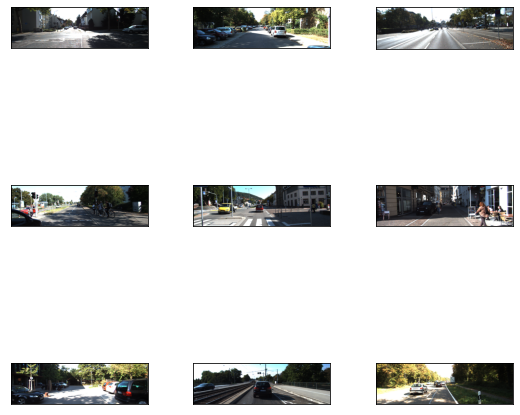

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## (2) 데이터 직접 확인하기

----Example----
['image', 'image/file_name', 'objects']
-------objects------
{'alpha': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.66,  0.14,  0.19,  0.3 ,  0.34,  0.38,  0.34, -2.62, -2.57,
       -1.64], dtype=float32)>, 'bbox': <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0.43506667, 0.53369564, 0.52034664, 0.5683897 ],
       [0.42792   , 0.34012076, 0.55792   , 0.4382367 ],
       [0.41917333, 0.3336554 , 0.5215733 , 0.4302657 ],
       [0.39064   , 0.2880032 , 0.51688   , 0.40672302],
       [0.37797335, 0.2736715 , 0.52416   , 0.40269727],
       [0.35266668, 0.25619164, 0.51386666, 0.39058775],
       [0.32642666, 0.21359098, 0.51882666, 0.3608615 ],
       [0.22733334, 0.0436715 , 0.51232   , 0.26206118],
       [0.13133334, 0.        , 0.48330668, 0.23534621],
       [0.46565333, 0.517665  , 0.5639733 , 0.5523752 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1.41, 1.65, 4.28],
       [1.99, 1.8 , 4.96],
  

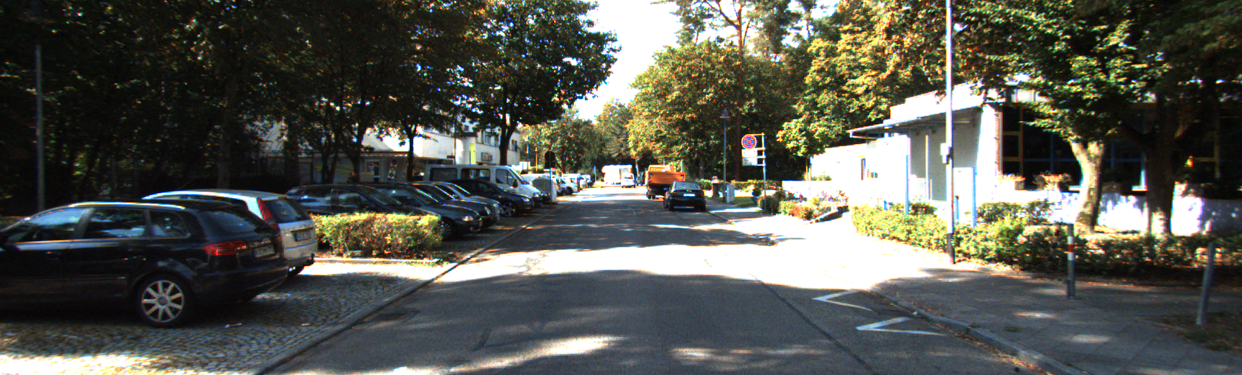

In [5]:
sample = ds_train.take(1)

# 이미지와 라벨 추출
for example in sample:
    print('----Example----')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']
    
print('-------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242 height: 375
(10, 4)
[662.85    211.85    705.94    179.87001]
[422.43    214.53    544.29    165.78001]
[414.4  217.81 534.39 179.41]
[357.69998 228.51001 505.15    181.17001]
[339.90002 233.26    500.15    178.43999]
[318.19003 242.75    485.11    182.3    ]
[265.28 252.59 448.19 180.44]
[ 54.239998 289.75     325.47998  182.88    ]
[  0.   325.75 292.3  193.76]
[642.93994 200.38    686.05    163.51001]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F7F1B6CBC50>


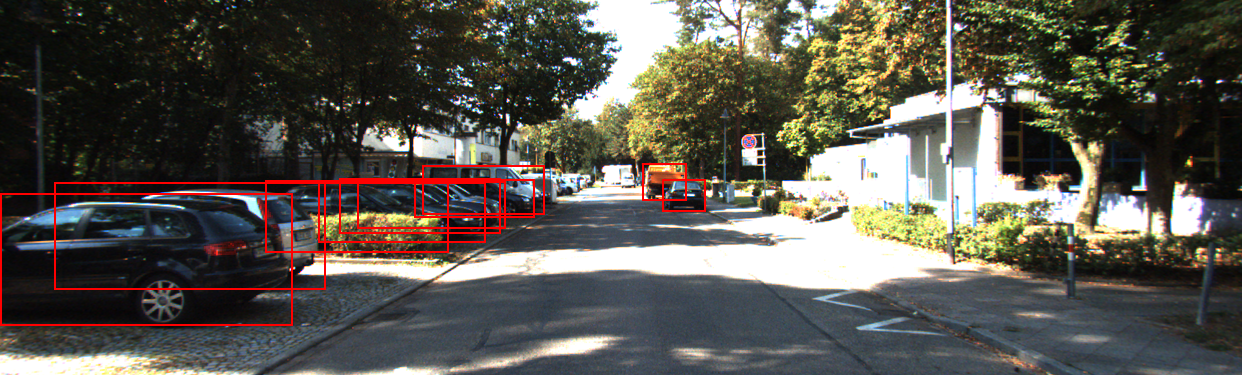

In [7]:
# 지이미지의 바운딩 박스 확인 - left, top, right, bottom
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, 'height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## Model 불러오기 - RetinaNet

* Focal loss
* Feature pyramid network(FPN)


### 클래스 및 바운딩 박스 정보 추출

In [11]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox normalized coord. -> pixel-oriented coord.
        x_min = object_bbox[:, 1] * width
        x_max = object_bbox[:, 3] * width
        y_min = height - object_bbox[:, 2] * height
        y_max = height - object_bbox[:, 0] * height
        
        # 동일 이미지의 여러 object들을 한 줄씩 DataFrame 에 append
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                'img_path': img_path,
                'x1': _rect[0],
                'y1': _rect[1],
                'x2': _rect[2],
                'y2': _rect[3],
                'class_name': type_class_map[_type]
            }, ignore_index=True)
            
    
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [24:51<00:00,  4.26it/s]


In [13]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:52<00:00,  4.12it/s]


In [14]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        'car': 0,
        'person': 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
    
save_class_format(class_txt_path)


Done
